In [1]:
# Install libraries
!pip install seedir
!pip install emoji
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 4.2 MB/s eta 0:00:00


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seedir as sd
from zipfile import ZipFile
import plotly.express as px
import shutil
import cv2
import glob
from PIL import Image, ImageDraw
import json
import itertools

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stanford-cropped-images/names.csv
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/new-new-06156.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/06270.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/03575.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/07155.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/05238.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/new-new-02494.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/Dodge Ram Pickup 3500 Crew Cab 2010/02753.jpg
/kaggle/input/stanford-cropped-images/cars_recognition_train_test_va

In [4]:
names = pd.read_csv("/kaggle/input/stanford-cropped-images/names.csv")

In [5]:
names.head()

,Unnamed: 0,class_name,class_number
0,0,AM General Hummer SUV 2000,1
1,1,Acura RL Sedan 2012,2
2,2,Acura TL Sedan 2012,3
3,3,Acura TL Type-S 2008,4
4,4,Acura TSX Sedan 2012,5


In [6]:
## deep learning
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import efficientnet

In [7]:
train_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/train/*/*")
test_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/test/*/*")
valid_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/*/*")

In [8]:
model_names = names["class_name"].values.tolist()

In [9]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_car)
validation_samples = len(test_car)
testing_samples = len(valid_car)
## there are 196 different models
n_classes = len(model_names)
batch_size = 32

In [10]:
from keras.preprocessing.image import ImageDataGenerator

## performing augmentation on the training data
"""train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()"""
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/train"
test_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/test"

In [12]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 12950 images belonging to 196 classes.
Found 1597 images belonging to 196 classes.


## EfficientNetB1

In [13]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_2 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

27018416/27018416 [==============================] - 0s 0us/step


In [14]:
## compile model, define optimizer and the loss function
model_2.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [15]:
## train the model
history_2 = model_2.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-05 23:08:05.490093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 356s 790ms/step - loss: 4.4960 - accuracy: 0.1188 - val_loss: 5.1042 - val_accuracy: 0.0288
Epoch 2/20
405/405 [==============================] - 264s 651ms/step - loss: 2.6051 - accuracy: 0.4234 - val_loss: 1.9787 - val_accuracy: 0.5297
Epoch 3/20
405/405 [==============================] - 262s 648ms/step - loss: 1.6532 - accuracy: 0.6072 - val_loss: 1.3160 - val_accuracy: 0.6744
Epoch 4/20
405/405 [==============================] - 264s 651ms/step - loss: 1.1905 - accuracy: 0.7021 - val_loss: 1.0533 - val_accuracy: 0.7257
Epoch 5/20
405/405 [==============================] - 266s 656ms/step - loss: 0.9091 - accuracy: 0.7697 - val_loss: 0.8586 - val_accuracy: 0.7796
Epoch 6/20
405/405 [==============================] - 263s 649ms/step - loss: 0.7581 - accuracy: 0.8035 - val_loss: 0.7891 - val_accuracy: 0.7783
Epoch 7/20
405/405 [==============================] - 264s 651ms/step - loss: 0.6251 - accuracy: 0.8366 - val_loss: 0.7075 - val_accura

In [16]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
valid_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/"

In [18]:
testing_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1638 images belonging to 196 classes.


In [19]:
model_results = model_2.evaluate(testing_generator)

52/52 [==============================] - 20s 394ms/step - loss: 0.5515 - accuracy: 0.8535


In [20]:
import matplotlib.pyplot as plt

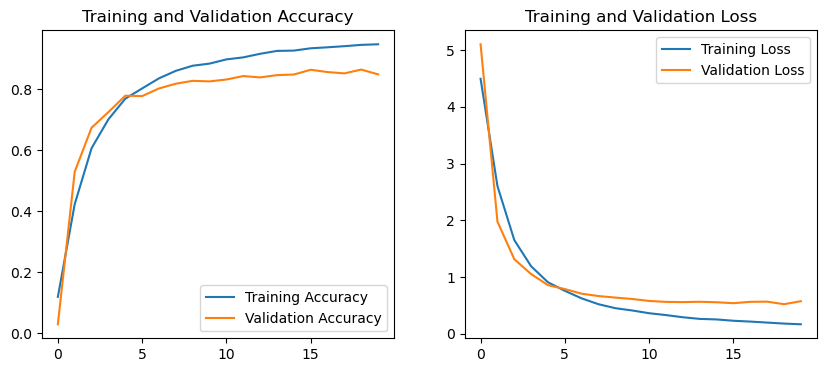

In [21]:
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# save the weights
model_2.save_weights('/kaggle/working/efficientnetB1_weights.h5')

## InceptronV3

In [23]:
from keras.applications.inception_v3 import InceptionV3

In [24]:
## loading the EfficientNetB1 model
base_model = InceptionV3(weights=None, include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_3 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

In [25]:
## compile model, define optimizer and the loss function
model_3.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [26]:
## train the model
history_3 = model_3.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
405/405 [==============================] - 266s 603ms/step - loss: 5.6447 - accuracy: 0.0096 - val_loss: 5.5773 - val_accuracy: 0.0044
Epoch 2/20
405/405 [==============================] - 245s 605ms/step - loss: 5.4403 - accuracy: 0.0151 - val_loss: 5.8692 - val_accuracy: 0.0263
Epoch 3/20
405/405 [==============================] - 246s 607ms/step - loss: 5.3216 - accuracy: 0.0207 - val_loss: 6.3132 - val_accuracy: 0.0225
Epoch 4/20
405/405 [==============================] - 243s 601ms/step - loss: 5.2426 - accuracy: 0.0259 - val_loss: 6.0834 - val_accuracy: 0.0313
Epoch 5/20
405/405 [==============================] - 243s 600ms/step - loss: 5.1744 - accuracy: 0.0266 - val_loss: 6.2512 - val_accuracy: 0.0276
Epoch 6/20
405/405 [==============================] - 246s 606ms/step - loss: 5.1038 - accuracy: 0.0341 - val_loss: 5.8961 - val_accuracy: 0.0326
Epoch 7/20
405/405 [==============================] - 243s 599ms/step - loss: 5.0442 - accuracy: 0.0351 - val_loss: 6.3434 -

In [27]:
model_results = model_3.evaluate(testing_generator)

52/52 [==============================] - 14s 258ms/step - loss: 5.7827 - accuracy: 0.0470


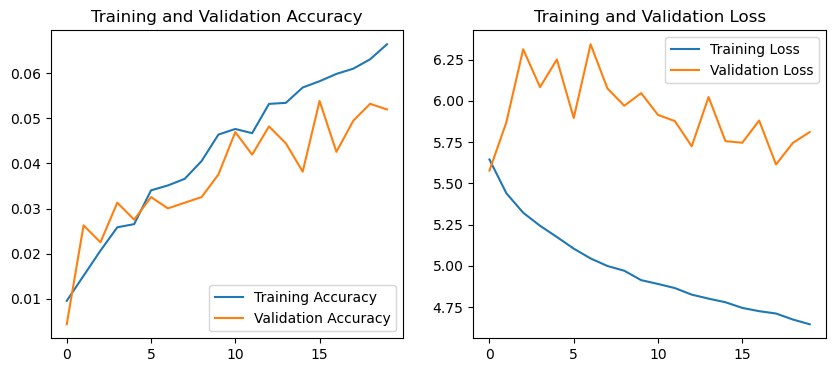

In [28]:
acc_2 = history_3.history['accuracy']
val_acc_2 = history_3.history['val_accuracy']

loss_2 = history_3.history['loss']
val_loss_2 = history_3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## EfficientNetB7

In [29]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB7(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_4 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

258076736/258076736 [==============================] - 2s 0us/step


In [30]:
## compile model, define optimizer and the loss function
model_4.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [31]:
## train the model
history_4 = model_4.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-06 02:09:19.346363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 645s 1s/step - loss: 4.4188 - accuracy: 0.1361 - val_loss: 4.3544 - val_accuracy: 0.0983
Epoch 2/20
405/405 [==============================] - 570s 1s/step - loss: 2.2472 - accuracy: 0.4900 - val_loss: 1.4581 - val_accuracy: 0.6487
Epoch 3/20
405/405 [==============================] - 568s 1s/step - loss: 1.2640 - accuracy: 0.6878 - val_loss: 0.9882 - val_accuracy: 0.7439
Epoch 4/20
405/405 [==============================] - 568s 1s/step - loss: 0.8305 - accuracy: 0.7829 - val_loss: 0.8052 - val_accuracy: 0.7802
Epoch 5/20
405/405 [==============================] - 567s 1s/step - loss: 0.6168 - accuracy: 0.8415 - val_loss: 0.6851 - val_accuracy: 0.8084
Epoch 6/20
405/405 [==============================] - 567s 1s/step - loss: 0.4683 - accuracy: 0.8728 - val_loss: 0.6446 - val_accuracy: 0.8272
Epoch 7/20
405/405 [==============================] - 566s 1s/step - loss: 0.3911 - accuracy: 0.8893 - val_loss: 0.6060 - val_accuracy: 0.8359
Epoch 8/20

In [32]:
model_results = model_4.evaluate(testing_generator)

52/52 [==============================] - 21s 387ms/step - loss: 0.4961 - accuracy: 0.8736


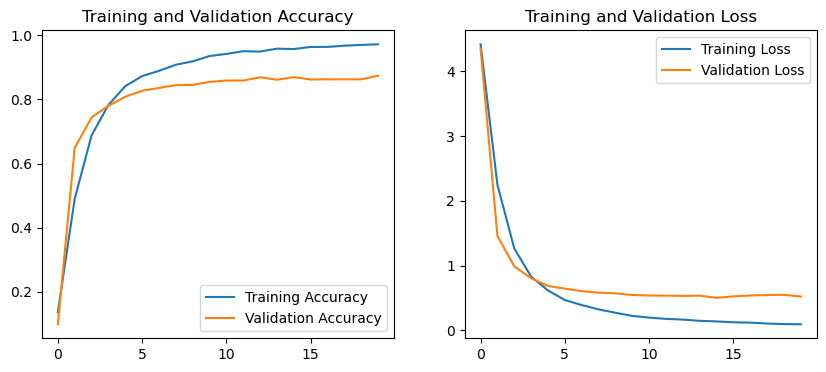

In [33]:
acc_2 = history_4.history['accuracy']
val_acc_2 = history_4.history['val_accuracy']

loss_2 = history_4.history['loss']
val_loss_2 = history_4.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## MobileNetV2

In [34]:
#Fine tuning base model to better suit our application, small learning rate
IMG_SHAPE = (224,224,3)

base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_5 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


# model_2.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [35]:
## compile model, define optimizer and the loss function
model_5.compile(loss='categorical_crossentropy',
              optimizer = tensorflow.keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [36]:
## train the model
history_5 = model_5.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
405/405 [==============================] - 260s 605ms/step - loss: 4.1722 - accuracy: 0.1454 - val_loss: 4.0180 - val_accuracy: 0.1296
Epoch 2/20
405/405 [==============================] - 244s 602ms/step - loss: 2.3553 - accuracy: 0.4364 - val_loss: 3.1932 - val_accuracy: 0.2655
Epoch 3/20
405/405 [==============================] - 239s 590ms/step - loss: 1.6268 - accuracy: 0.5868 - val_loss: 2.7622 - val_accuracy: 0.3563
Epoch 4/20
405/405 [==============================] - 240s 592ms/step - loss: 1.2548 - accuracy: 0.6685 - val_loss: 2.2263 - val_accuracy: 0.4483
Epoch 5/20
405/405 [==============================] - 239s 589ms/step - loss: 1.0286 - accuracy: 0.7208 - val_loss: 1.8952 - val_accuracy: 0.5266
Epoch 6/20
405/405 [==============================] - 240s 593ms/step - loss: 0.8895 - accuracy: 0.7536 - val_loss: 1.5553 - val_accuracy: 0.6111
Epoch 7/20
405/405 [==============================] - 238s 588ms/step - loss: 0.7756 - accuracy: 0.7820 - val_loss: 1.3453 -

In [37]:
model_results = model_5.evaluate(testing_generator)

52/52 [==============================] - 13s 257ms/step - loss: 0.8527 - accuracy: 0.7912


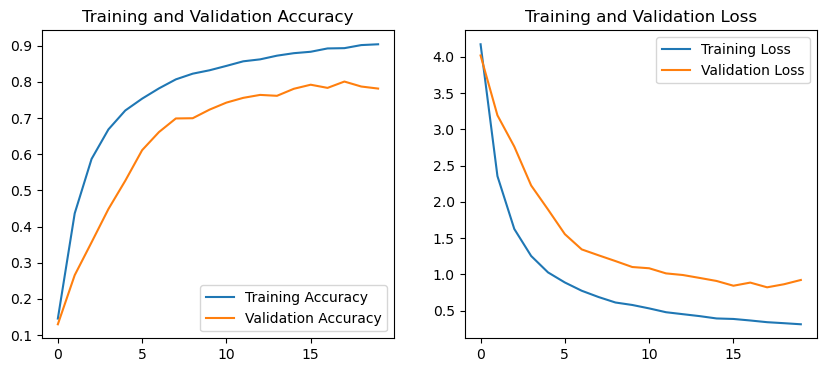

In [38]:
acc_2 = history_5.history['accuracy']
val_acc_2 = history_5.history['val_accuracy']

loss_2 = history_5.history['loss']
val_loss_2 = history_5.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
# save entire model to a HDF5 file
model_5.save('/kaggle/working/mobilenetV2.h5')

In [40]:
# save the weights
model_5.save_weights('/kaggle/working/mobilenetV2_weights.h5')